In [14]:
# %load_ext autoreload
# %autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.append('../')

/tmp/ipykernel_69775/4126939348.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [15]:
import math
import argparse
import h5py
import importlib
import numpy as np
import torch
import time
import sys
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import pickle

from models.vae_flow import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from models.shower_flow import compile_HybridTanH_model
from configs import Configs
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, Xmax, Xmin, Zmax, Zmin
import utils.gen_utils as gen_utils


import k_diffusion as K


cfg = Configs()

print(cfg.__dict__)

{'name': 'CD_', 'comet_project': 'calo-consistency', 'Acomment': 'long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA', 'log_comet': True, 'model_name': 'epicVAE_nFlow_kDiffusion', 'latent_dim': 0, 'beta_1': 0.0001, 'beta_T': 0.02, 'sched_mode': 'quardatic', 'flexibility': 0.0, 'truncate_std': 2.0, 'latent_flow_depth': 14, 'latent_flow_hidden_dim': 256, 'num_samples': 4, 'features': 4, 'sample_num_points': 2048, 'kl_weight': 0.001, 'residual': False, 'cond_features': 2, 'norm_cond': True, 'kld_min': 1.0, 'use_epic': False, 'epic_layers': 5, 'hid_d': 128, 'sum_scale': 0.001, 'weight_norm': True, 'flow_model': 'PiecewiseRationalQuadraticCouplingTransform', 'flow_transforms': 10, 'flow_layers': 2, 'flow_hidden_dims': 128, 'tails': 'linear', 'tail_bound': 10, 'dataset': 'x36_grid', 'dataset_path': '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5', 'quantized_pos': F

In [16]:
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, plt_cog
from utils.plotting import cfg as cfg_plt
import utils.plotting as plotting
importlib.reload(plotting)

import numpy as np
import h5py
import matplotlib.pyplot as plt

100%|██████████| 30/30 [00:00<00:00, 289.63it/s]


In [17]:
title = r'\textbf{full spectrum}' #  r'\textbf{50 GeV}'
real_label = r'\textsc{Geant4}'
ddpm_label = r'\textsc{CaloClouds}'
edm_label = r'\textsc{CaloClouds II}'
cm_label = r'\textsc{CaloClouds II (CM)}'

# CoG

In [18]:
with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/c_cog_real.pickle', 'rb') as f:
    c_cog_real = pickle.load(f)
with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/c_cog_fake.pickle', 'rb') as f:
    c_cog_fake = pickle.load(f)
print('pickle loaded')

pickle loaded


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 288.36it/s]


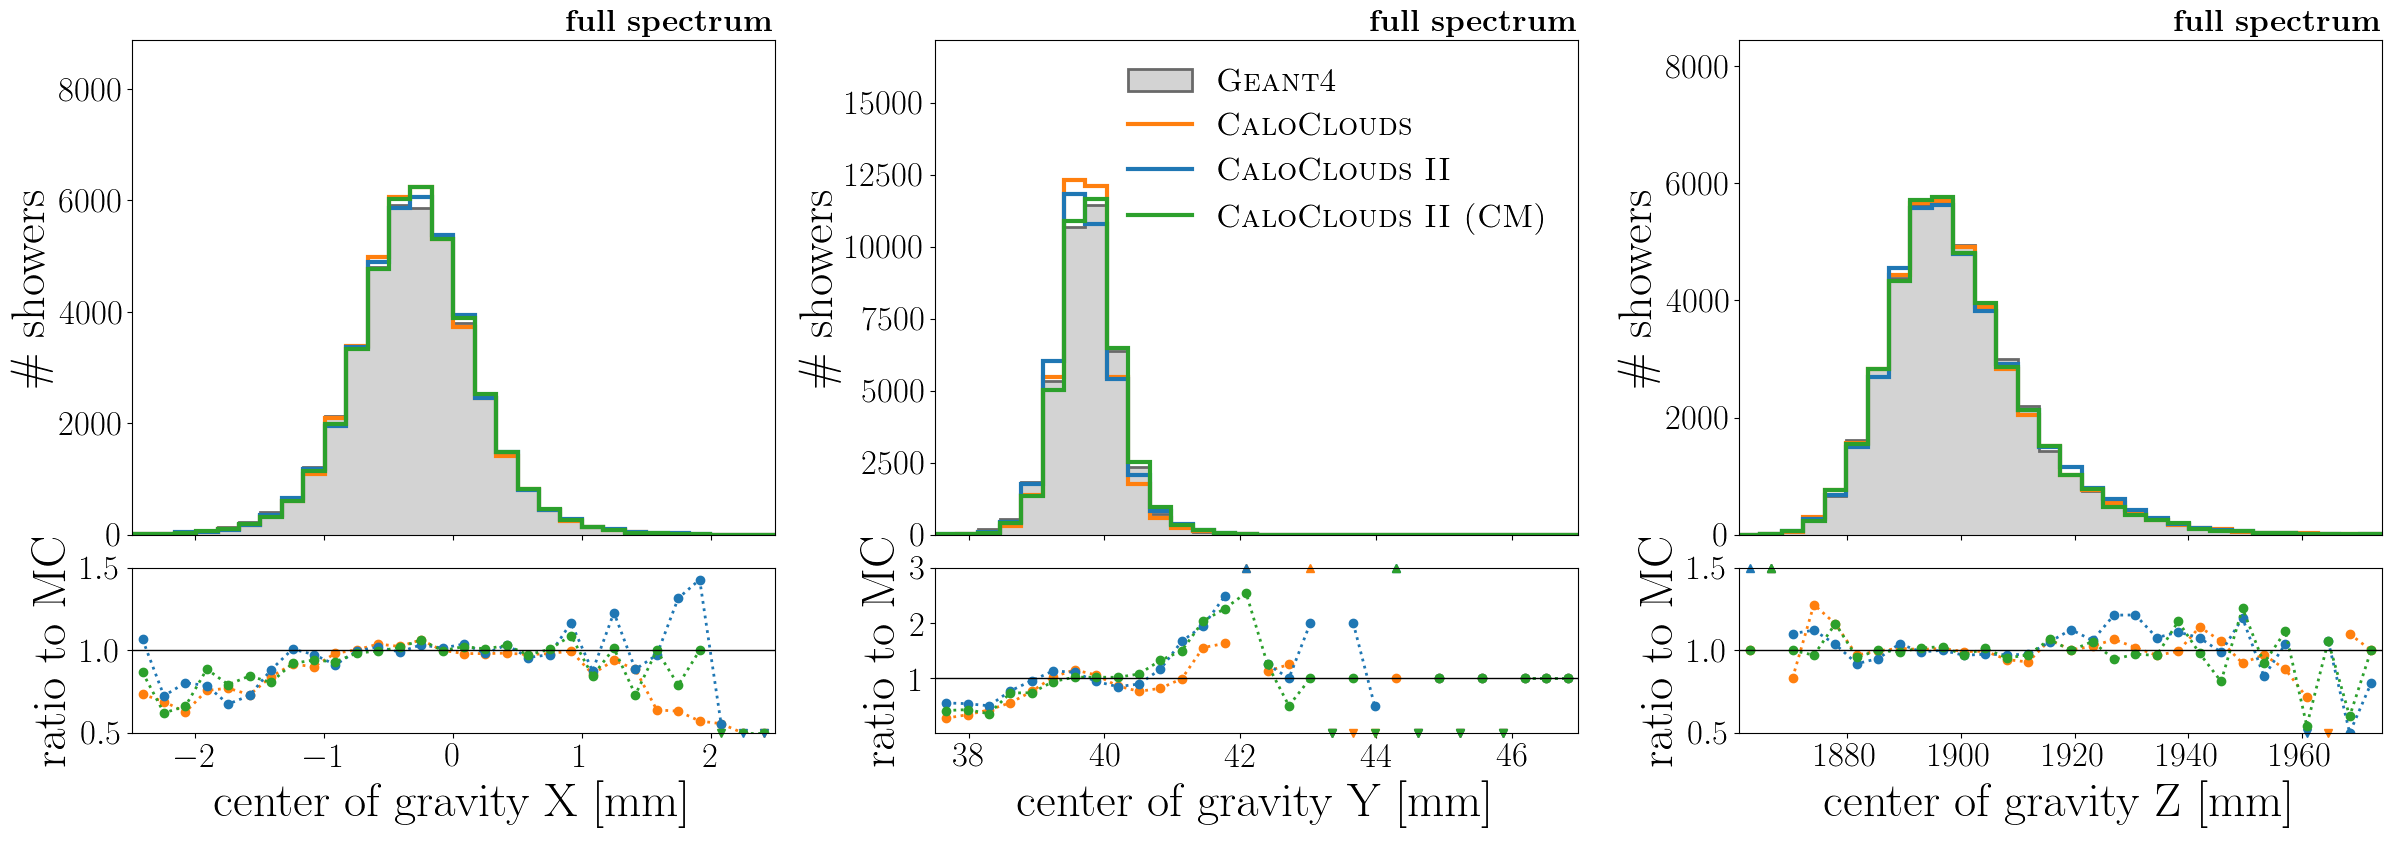

In [81]:
importlib.reload(plotting)
plotting.plt_cog(c_cog_real, c_cog_fake, [real_label, ddpm_label, edm_label, cm_label], title=title)

# other plots

In [25]:
with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/real_list.pickle', 'rb') as f:
    real_list = pickle.load(f)
with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/fakes_list.pickle', 'rb') as f:
    fakes_list = pickle.load(f)
print('pickle loaded')

pickle loaded


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 284.98it/s]


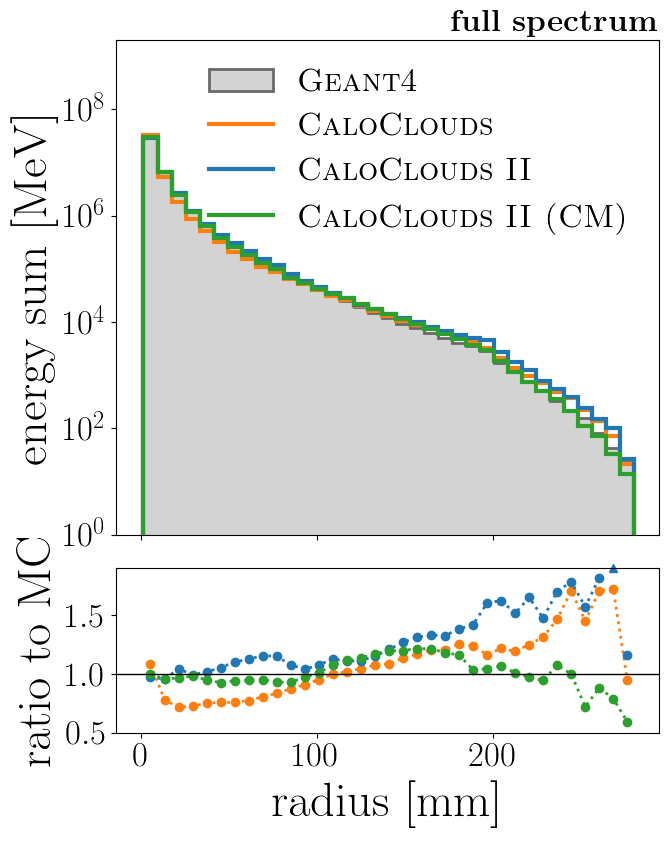

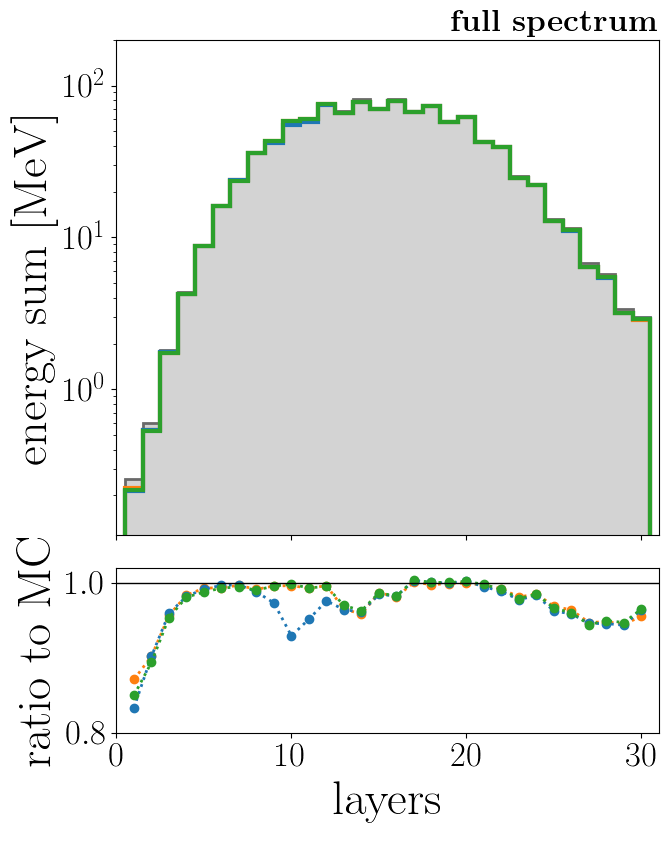

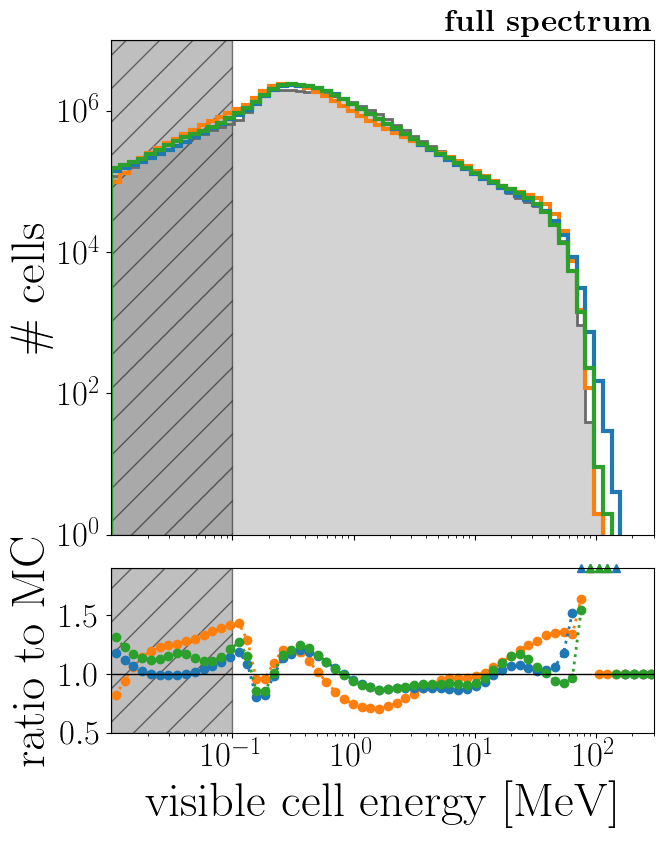

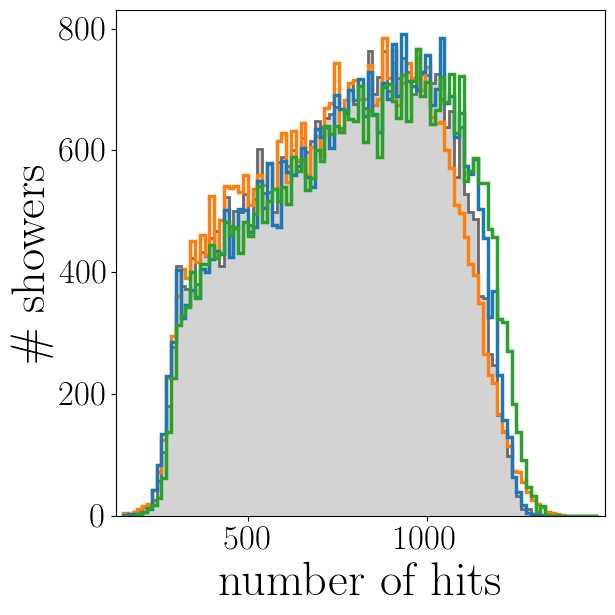

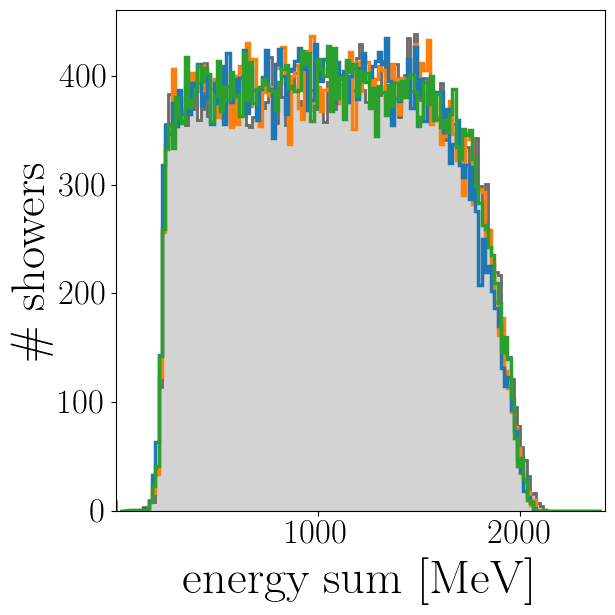

In [82]:
importlib.reload(plotting)

plotting.get_plots_from_observables(real_list, fakes_list, labels = [real_label, ddpm_label, edm_label, cm_label], title=title)